# Signal Detection Theory and psychophysical mappings

In [1]:
using Distributions
using LaTeXStrings
import PyPlot; plt = PyPlot

save_figures = false

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273
┌ Info: Precompiling LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


false

## Standard SDT
The internal decision axis in SDT. $d' = \frac{(\mu_2 - \mu_1)}{\sigma}$, where the $\mu_i$ are the means of the noise and signal distributions and $\sigma$ is their common standard deviation.

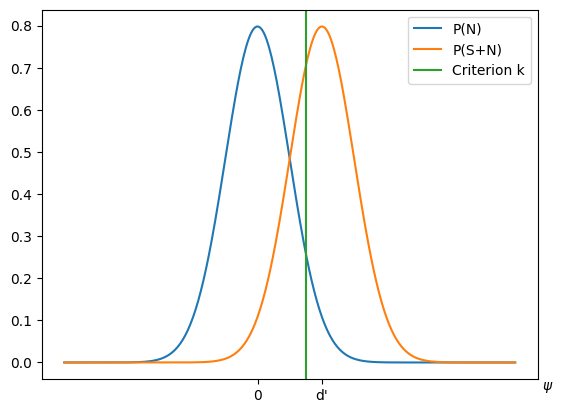

In [2]:
# psychological decision variable
ψ = collect(-2.5:0.02:4.5)

# fix SDT parameters d' and a criterion k for illustration purposes
μ1 = 0.5
μ2 = 1.5
σ = .5
n = Normal(μ1, σ)
s = Normal(μ2, σ)
dprime = (μ2 - μ1) / σ
k = 1.25

# plot
f, ax = plt.subplots()
ax.plot(ψ, pdf.(n, ψ), label="P(N)")
ax.plot(ψ, pdf.(s, ψ), label="P(S+N)")
ax.set_xlabel(L"\psi")
ax.xaxis.set_label_coords(1.02,0)
plt.xticks([μ1, μ2], [0, "d'"])
ax.axvline([k], label="Criterion k", C="C2")
ax.legend()
if save_figures f.savefig("../figures/sdt.pdf") end

## Psychophysical mappings and the Gaussian assumption
If we additionally want to make statements about the relationship of physical stimulus properties and responses, e.g. in the form of a psychometric curve, we have to make (explicit or implicit) assumptions about the shape of the psychophysical mapping.

Whenever one fits a psychometric function to physical stimulus values and response probabilities, this can be interpreted in terms of implicit assumptions on the noise distribution and psychophysical mapping. For example, imagine we analyze data from a contrast discrimination task under the assumption that decisions are made on an internal axis with Gaussian noise distribtions and that contrast perception scales with Fechner's law. In that case, the internal decision variable $\psi$ depends logarithmically on the physical variable $\phi$: $\psi = \ln{\varphi}.$ If we now make the standard assumption (as in SDT) that $\psi \sim \mathcal{N}(\mu, \sigma^2)$, it follows from the definition of the log-normal distribution that $\varphi \sim \text{Lognormal}(\mu, \sigma^2)$

In [3]:
function plot_mapping(mapping, x; μ1=1.5, μ2=2.5, σ=0.5)
    
    # compute transformation from physical to psychological space
    y = mapping.(x)
    
    # make plot of mapping and distributions with PyPlot
    f, axes = plt.subplots(2, 2, sharex="col",
                gridspec_kw=Dict("width_ratios"=>[0.1, 0.9], "height_ratios"=>[0.9, 0.1]))
    
    # signal and noise distributions on the internal axis
    noise = Normal(μ1, σ)
    signal = Normal(μ2, σ)
    
    # plot the mapping
    axes[1,2].plot(x, y, color="C2")
    axes[1,2].set_yticklabels([])
    axes[1,2].set_ylabel(L"\psi", rotation=0)
    axes[1,2].yaxis.set_label_coords(0,1.02)
    axes[1,2].set_xlabel(L"\varphi", rotation=0)
    axes[1,2].xaxis.set_label_coords(1.02,0)

    # distributions on the psychological axis (Gaussian)
    axes[1,1].plot(pdf.(noise, y), y)
    axes[1,1].plot(pdf.(signal, y), y)
    axes[1,1].invert_xaxis()
    axes[1,1].axis("off")

    # distributions following from the assumptions on the physical axis (warped and renormalized Gaussian, e.g. log-normal if mapping=log)
    axes[2,2].plot(x, pdf.(noise, y) / sum(pdf.(noise, y)))
    axes[2,2].plot(x, pdf.(signal, y)/ sum(pdf.(signal, y)))
    axes[2,2].invert_yaxis()
    axes[2,2].axis("off")

    axes[2,1].remove()
    
    f.tight_layout()
    
    return f, axes[1,2]
end

plot_mapping (generic function with 1 method)

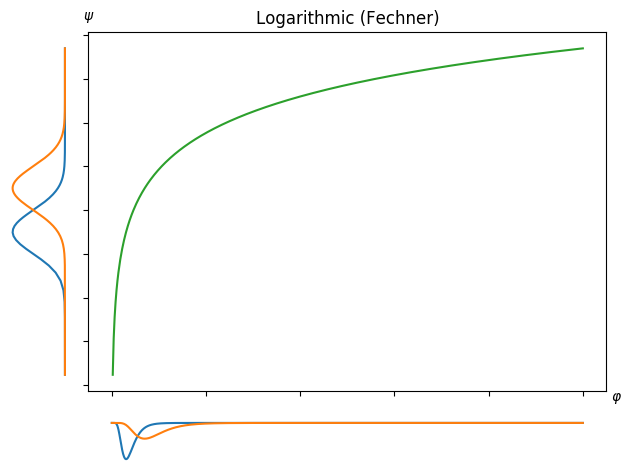

In [4]:
fechner_law(x) = 1.2 * log(x) + 1

ϕ = collect(0:0.1:50)

f, ax = plot_mapping(fechner_law, ϕ)
ax.set_title("Logarithmic (Fechner)")
if save_figures f.savefig("../figures/mapping-log.pdf") end

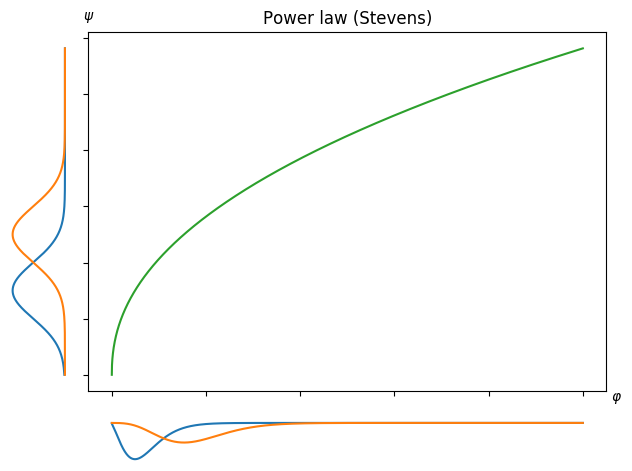

In [5]:
power(x) = x^0.45

ϕ = collect(0:0.01:50)

f, ax = plot_mapping(power, ϕ)
ax.set_title("Power law (Stevens)")
if save_figures f.savefig("figures/mapping-power.pdf") end

This has implications for the interpretation of the standard practice of fitting psychometric functions. If we fit a cumulative Gaussian to the reponse probabilities from a psychophysical experiment at different physical levels of stimulus intensity, we make the implicit assumption that the psychophysical mapping is linear (if we assume that the internal decision axis has equal Gaussian noise everywhere

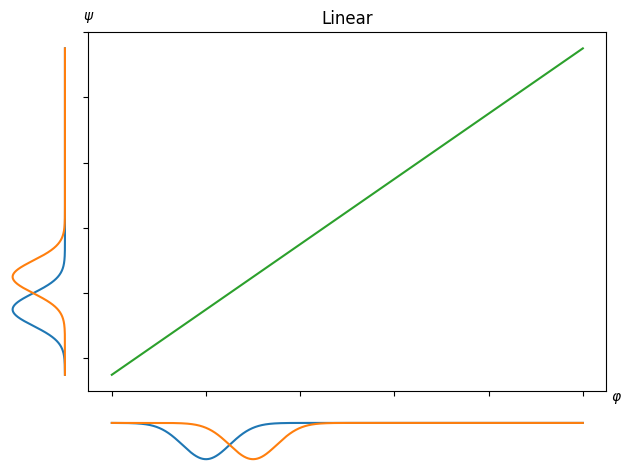

In [6]:
linear(x) = 0.2 * x - 0.5

ϕ = collect(0:0.01:50)

f, ax = plot_mapping(linear, ϕ)
ax.set_title("Linear")
if save_figures f.savefig("../figures/mapping-linear.pdf") end

## Efficient coding
Recently, alternative psychophysical laws have been proposed in the context of efficient coding (Ganguli & Simoncelli, 2014; Wei & Stocker, 2015). Abstracting away the neural implementation aspect, the idea is that the psychophysical mapping is the cumulative distribution of the environmental distribution of stimuli.

The empirical distributions of many stimuli are emprirically well fit by power-law distributions. For example, according to the data presented by Ganguli & Simoncelli (2016, arXiv), the distributions of spatial frequency in natural images can be summarized by a modified power law function:

$$
d(x) = \frac{A}{x_0^p + x^p}
$$

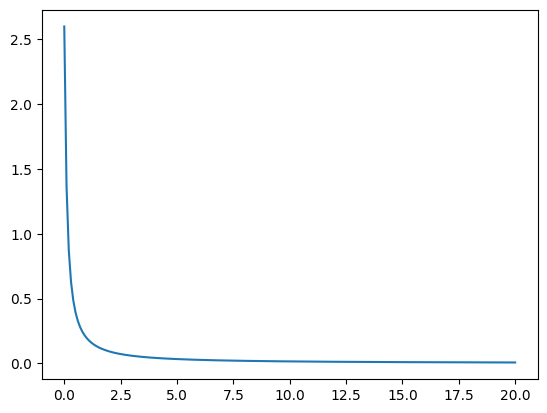

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dd7c75490>

In [7]:
A = 0.21; x0 = 0.11; b = 1.14

function p(x)::Float64
    return A / (x0^b + x^b)
end

ϕ = collect(0:0.1:20)

plt.plot(ϕ, p.(ϕ))

If we compute the cumulative distribution of the stimulus variable by integrating $d(x)$, we again get a power law.

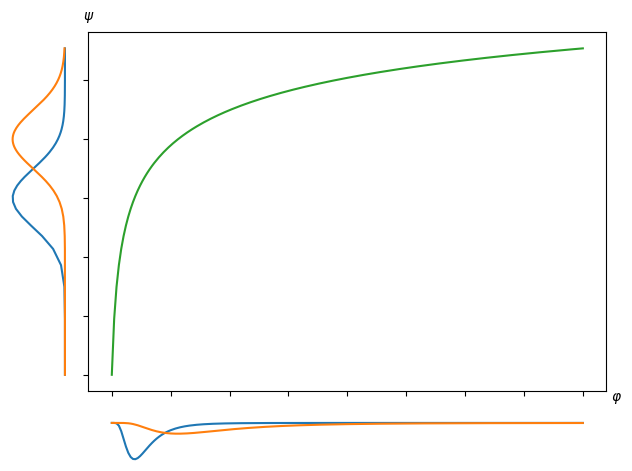

In [9]:
function F(x)
    integral, err = quadgk(p, 0, x, rtol=1e-8)
    return integral
end

f, ax = plot_mapping(F, ϕ, μ1=0.6, μ2=0.8, σ=0.1)

if true f.savefig("../figures/efficient-coding.pdf") end

Another example is visual orientation, a circular variable, for which neither Fechner's nor Stevens' law holds. The environmental distribution of visual orientation has sharp peaks at the obliques and can be summarizes in the form:

$$
d(x) = c \, (\frac{1}{c} - |\sqrt{\sin{x}}|)
$$

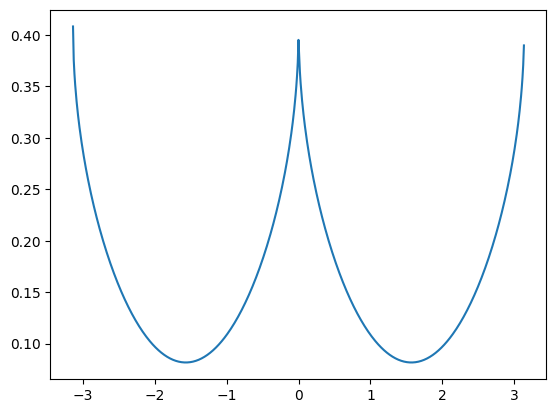

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dd76f7550>

In [10]:
c = 0.8

p_u(x) = c * ((1 / c) - abs(sqrt(Complex(sin(x)))))

normconst = quadgk(p_u, -pi, pi, rtol=1e-8)[1]
p(x) = p_u(x) ./ normconst

ϕ = collect(-pi:0.01:pi)

plt.plot(ϕ, p.(ϕ))

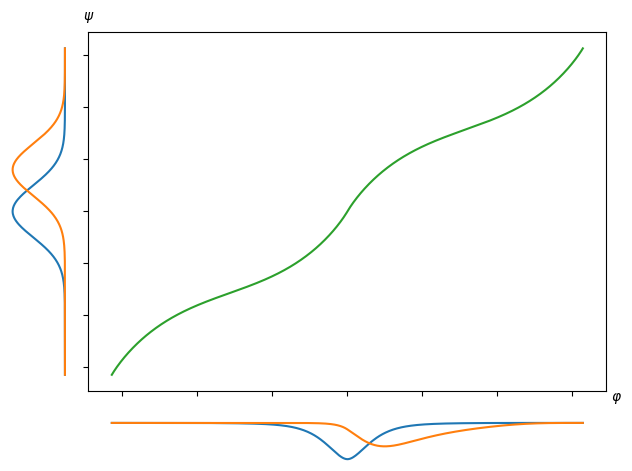

In [11]:
function F(x)
    integral, err = quadgk(p, -pi, x, rtol=1e-8)
    return (2 * pi * integral) - pi
end

f, ax = plot_mapping(F, ϕ, μ1=0, μ2=0.8, σ=0.5)

if save_figures f.savefig("../figures/efficient-coding-ori.pdf") end

### Discriminability

We assume that the discriminability $\delta$ in the sensory representation is constant. From this assumption and the mapping from physical to sensory space, we can derive the discriminability in physical space. Under the Gaussian assumption with equal variance it follows that the discriminability at a particular position $\psi_0$ is

$$
\Delta(\psi_0) = \frac{ \hat\mu(\varphi_2) - \hat\mu(\varphi_1) }{ \sqrt{0.5 (\sigma^2(\varphi_2) + \sigma^2(\varphi_1)} },
$$

where $(\varphi_1, \varphi_2) = (\varphi_0 - \Delta_\varphi / 2, \varphi_0 + \Delta_\varphi / 2)$. Without loss of generality, we can assume arbitrary scaling of the Gaussians on the sensory axis, which results in

$$
\Delta(\psi_0) =\hat\mu(\varphi_2) - \hat\mu(\varphi_1).
$$

The means of the Gaussians are given by the psychophysical mapping, in this case the CDF of the stimulus distribution F:

$$
\Delta(\psi_0) = F(\varphi_0 + \Delta_\varphi / 2) - F(\varphi_0 - \Delta_\varphi / 2)
$$

Approximating the CDF with a first-order Taylor approximation yields:


$$
\Delta(\psi_0) = F(\varphi_0) + \frac{\Delta_\varphi}{ 2}F'(\varphi_0) -F(\varphi_0) + \frac{\Delta_\varphi}{ 2} F'(\varphi_0)
$$

$$
= \Delta_\varphi F'(\varphi_0)
$$

$$
\Leftrightarrow D(\varphi_0) := \Delta_\varphi \propto \frac{1}{p(\varphi_0)}
$$

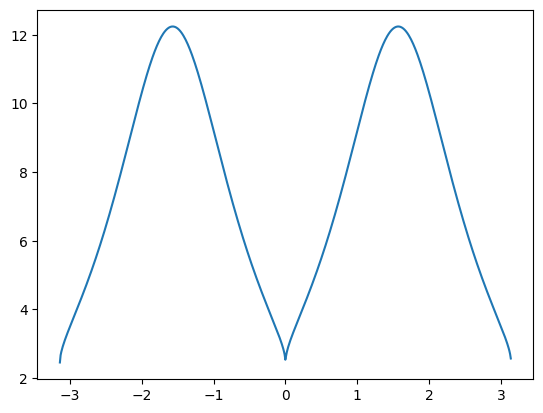

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dfc147fa0>

In [12]:
plt.plot(ϕ, 1 ./ p.(ϕ))